# Building MLP imbalance data for cic-ids 2017

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import MLP
from utils import (
    dataset,
    test,
    train,
    utils,
    visualisation
)

/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

Check if GPU is active.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

### Create the DataLoader

In [5]:
from sklearn.utils import resample
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=False)

#train_data也应该重新采样一些数据
train_data = resample(train_data, n_samples=140000, random_state=123, replace=False)

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 64

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  140000
# instances in validation set:  485146
# instances in testing set:  485145


### Instantiate the network, the loss function and the optimizer

In [6]:
# Creating a MLP
model = MLP(49, 64, 64, 7)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Epochs
num_epochs = 5

In [7]:
print(model)

MLP(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()

### Train it

In [9]:
from tqdm import tqdm
import logging
def train1(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            #labels = labels.squeeze(1)
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_loss += loss.cpu().item()
            train_loss += loss.item()
            train_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #train_output_pred += outputs.argmax(1).cpu().tolist()
            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()
        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                #labels = labels.squeeze(1)
                labels = labels.view(-1)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

In [10]:
device = 'cpu'
history = train1(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-04-02 17:51:37,086 | 3611660136.py:43 | Epoch 1/5:


100%|██████████| 2188/2188 [00:03<00:00, 671.94it/s]


INFO 2024-04-02 17:53:12,814 | 3611660136.py:105 | loss: 0.09151014957323303 - acc: 0.9750928571428571 - val_loss: 0.029964469113261123 - val_acc: 0.9938245394170002
INFO 2024-04-02 17:53:12,821 | 3611660136.py:43 | Epoch 2/5:


100%|██████████| 2188/2188 [00:03<00:00, 631.92it/s]


INFO 2024-04-02 17:54:48,113 | 3611660136.py:105 | loss: 0.029593008400591845 - acc: 0.9928857142857143 - val_loss: 0.021470381970100386 - val_acc: 0.9954508539697329
INFO 2024-04-02 17:54:48,115 | 3611660136.py:43 | Epoch 3/5:


100%|██████████| 2188/2188 [00:03<00:00, 661.67it/s]


INFO 2024-04-02 17:56:23,672 | 3611660136.py:105 | loss: 0.020905481837514298 - acc: 0.99525 - val_loss: 0.016873963850204777 - val_acc: 0.996471165381143
INFO 2024-04-02 17:56:23,676 | 3611660136.py:43 | Epoch 4/5:


100%|██████████| 2188/2188 [00:03<00:00, 639.62it/s]


INFO 2024-04-02 17:57:59,247 | 3611660136.py:105 | loss: 0.018185812067355936 - acc: 0.9957571428571429 - val_loss: 0.021867265489205992 - val_acc: 0.9942470926277863
INFO 2024-04-02 17:57:59,249 | 3611660136.py:43 | Epoch 5/5:


100%|██████████| 2188/2188 [00:03<00:00, 649.00it/s]


INFO 2024-04-02 17:59:34,669 | 3611660136.py:105 | loss: 0.016609245314685214 - acc: 0.9959071428571429 - val_loss: 0.014612544930328786 - val_acc: 0.9964752878514921
INFO 2024-04-02 17:59:34,673 | 3611660136.py:107 | Finished Training


### Plot loss vs iterations

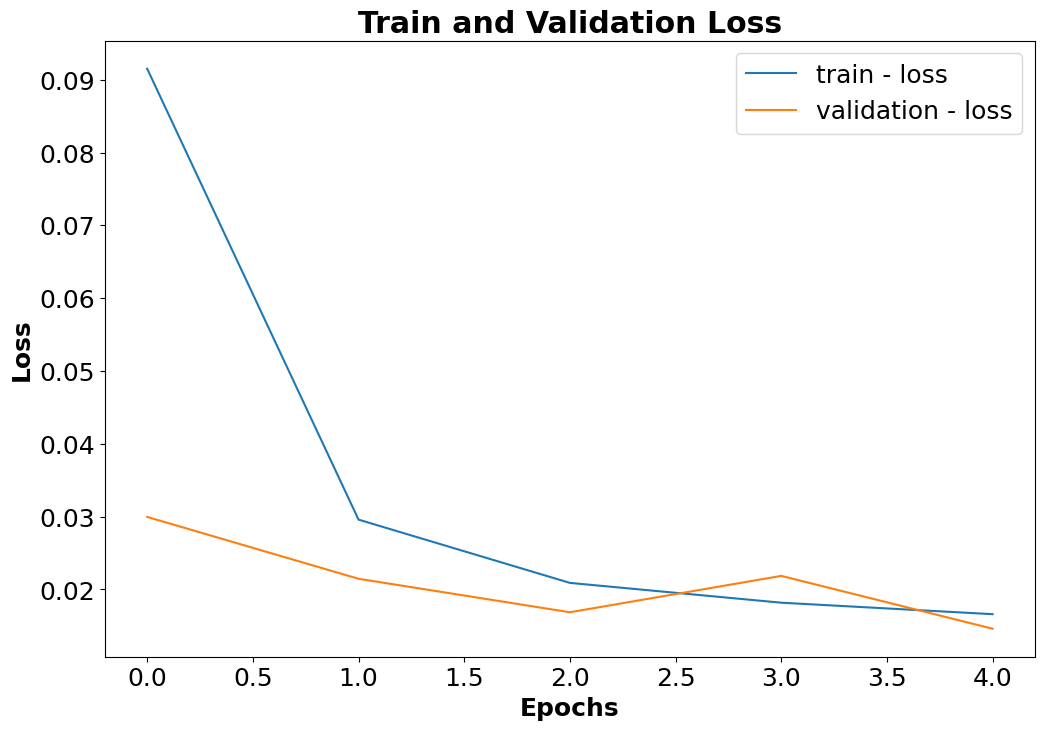

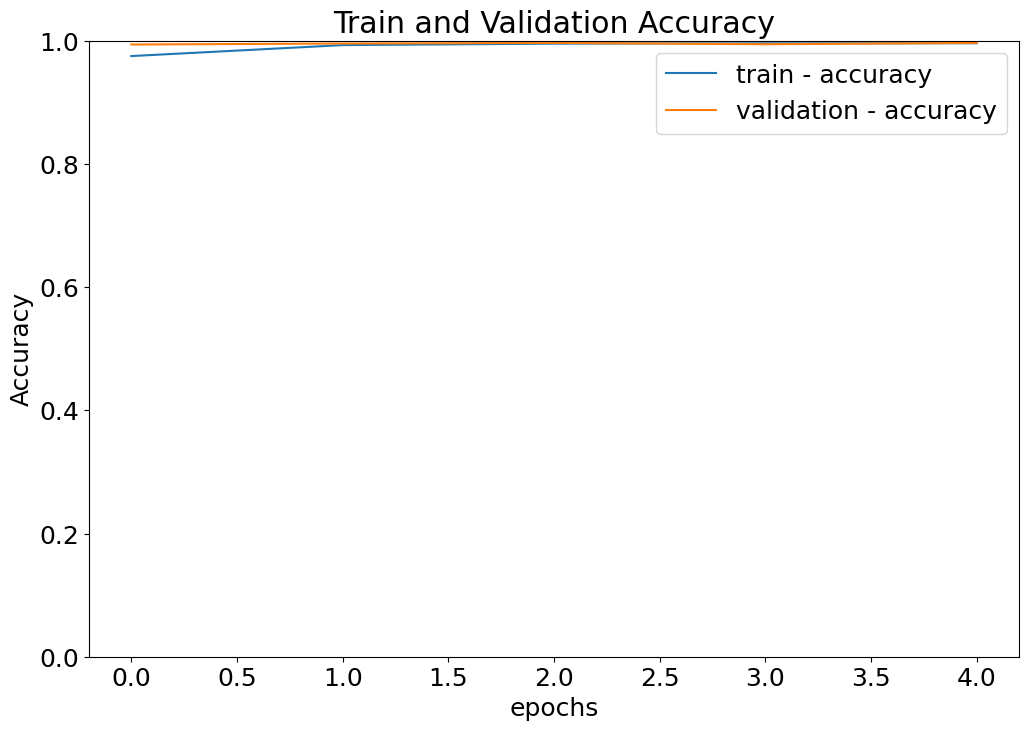

In [15]:
plt.rcParams['font.size'] = 18  # 设置标签的字体大小
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss", fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

../../utils/visualisation.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


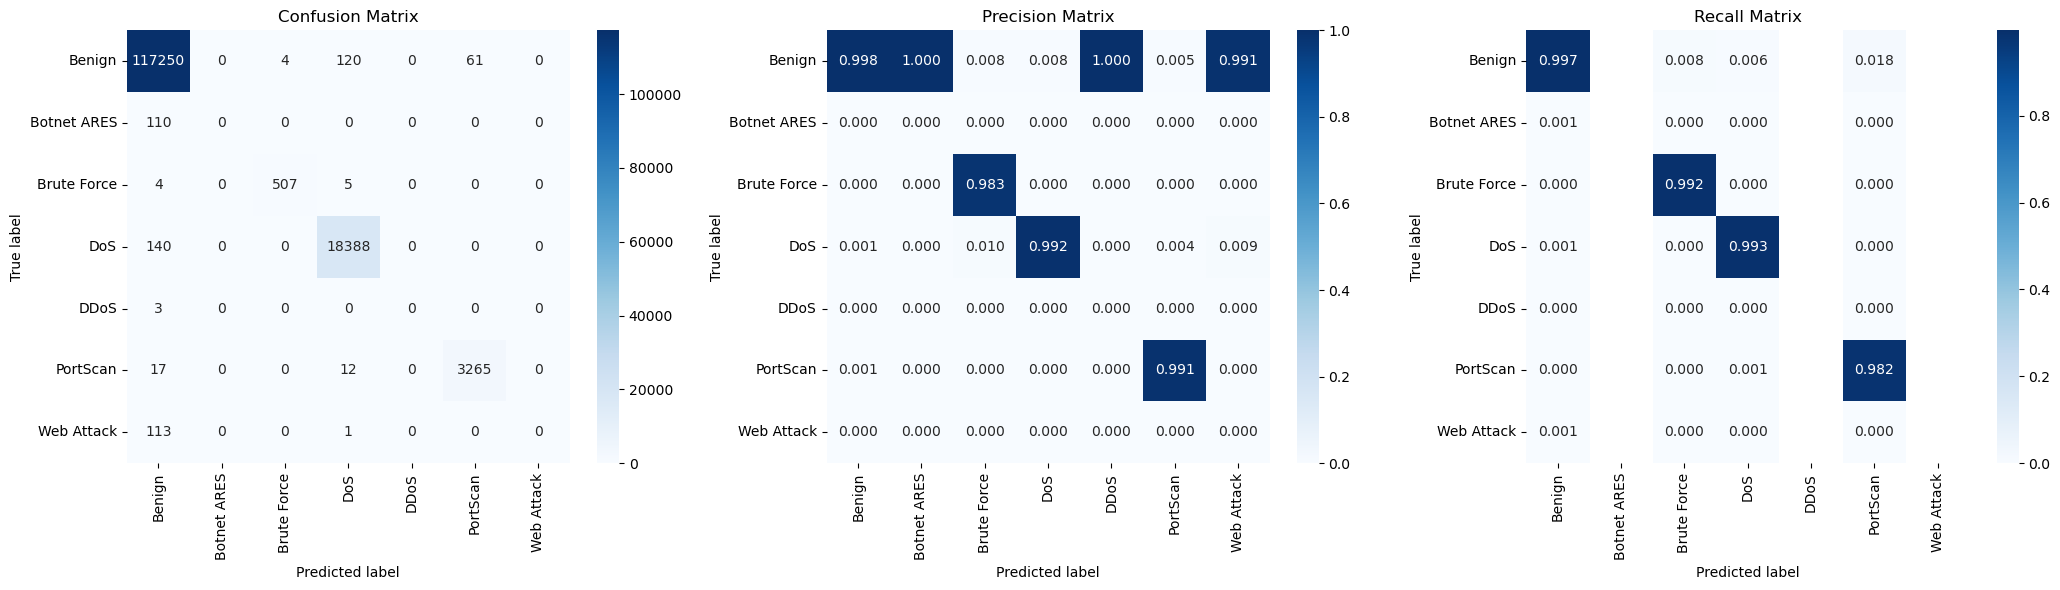

In [12]:
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS', 'DDoS', 'PortScan', 'Web Attack']

visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_mlp_train_confusion_matrix.pdf")

In [13]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    117435
 Botnet ARES       0.00      0.00      0.00       110
 Brute Force       0.99      0.98      0.99       516
         DoS       0.99      0.99      0.99     18528
        DDoS       0.00      0.00      0.00         3
    PortScan       0.98      0.99      0.99      3294
  Web Attack       0.00      0.00      0.00       114

    accuracy                           1.00    140000
   macro avg       0.57      0.57      0.57    140000
weighted avg       0.99      1.00      0.99    140000



/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


../../utils/visualisation.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


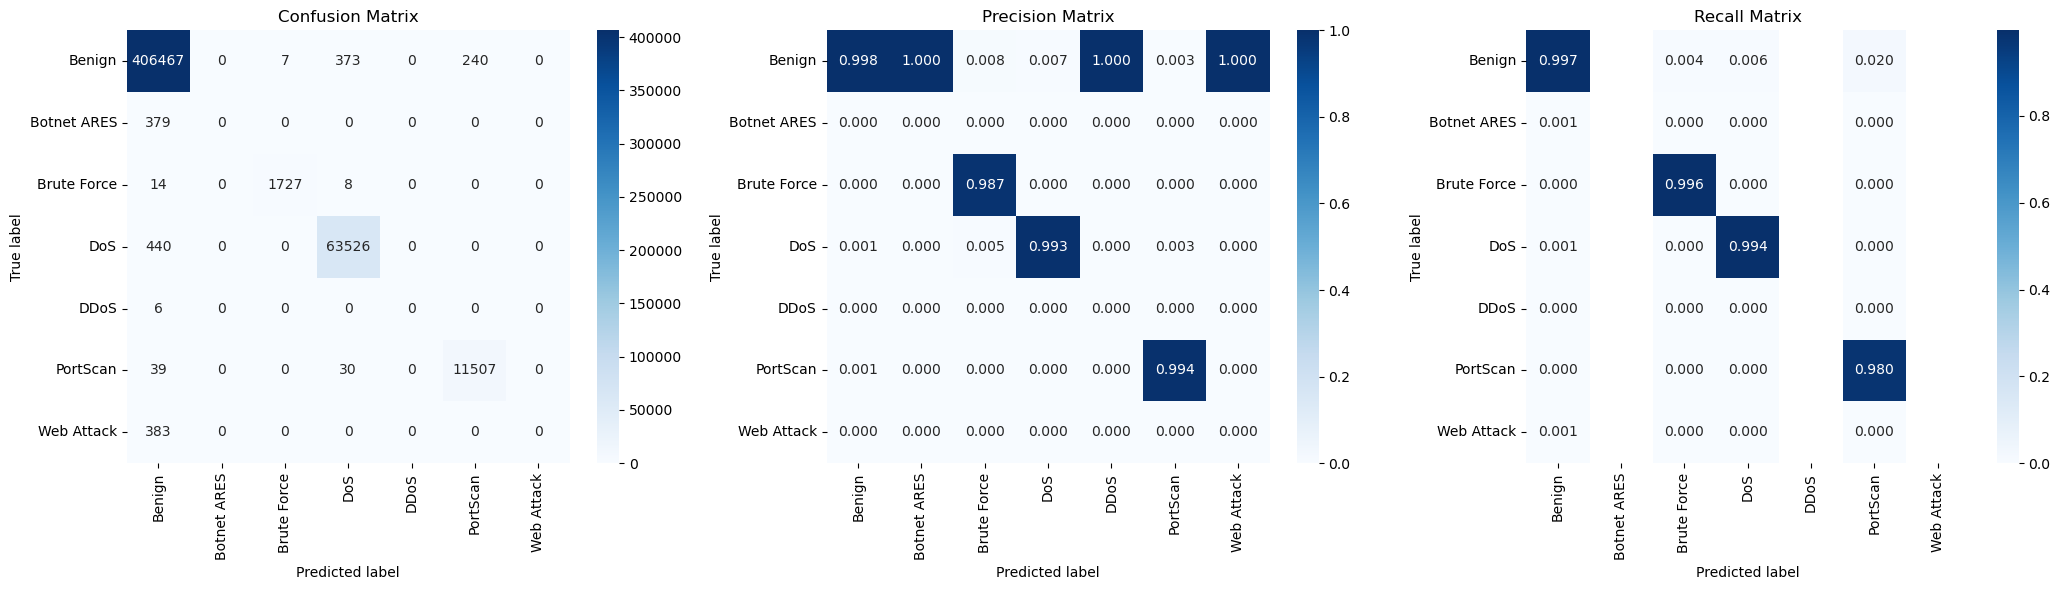

In [14]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_mlp_valid_confusion_matrix.pdf")

In [15]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report



/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    407087
 Botnet ARES       0.00      0.00      0.00       379
 Brute Force       1.00      0.99      0.99      1749
         DoS       0.99      0.99      0.99     63966
        DDoS       0.00      0.00      0.00         6
    PortScan       0.98      0.99      0.99     11576
  Web Attack       0.00      0.00      0.00       383

    accuracy                           1.00    485146
   macro avg       0.57      0.57      0.57    485146
weighted avg       0.99      1.00      1.00    485146



/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test it

In [17]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████| 7581/7581 [01:34<00:00, 80.32it/s]

INFO 2024-04-02 18:04:46,062 | test.py:82 | Test loss: 0.015045864296853596, Test accuracy: 0.9963969534881324


### Classification Report

../../utils/visualisation.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall_confusion_mtx = confusion_mtx / confusion_mtx.sum(axis=0)


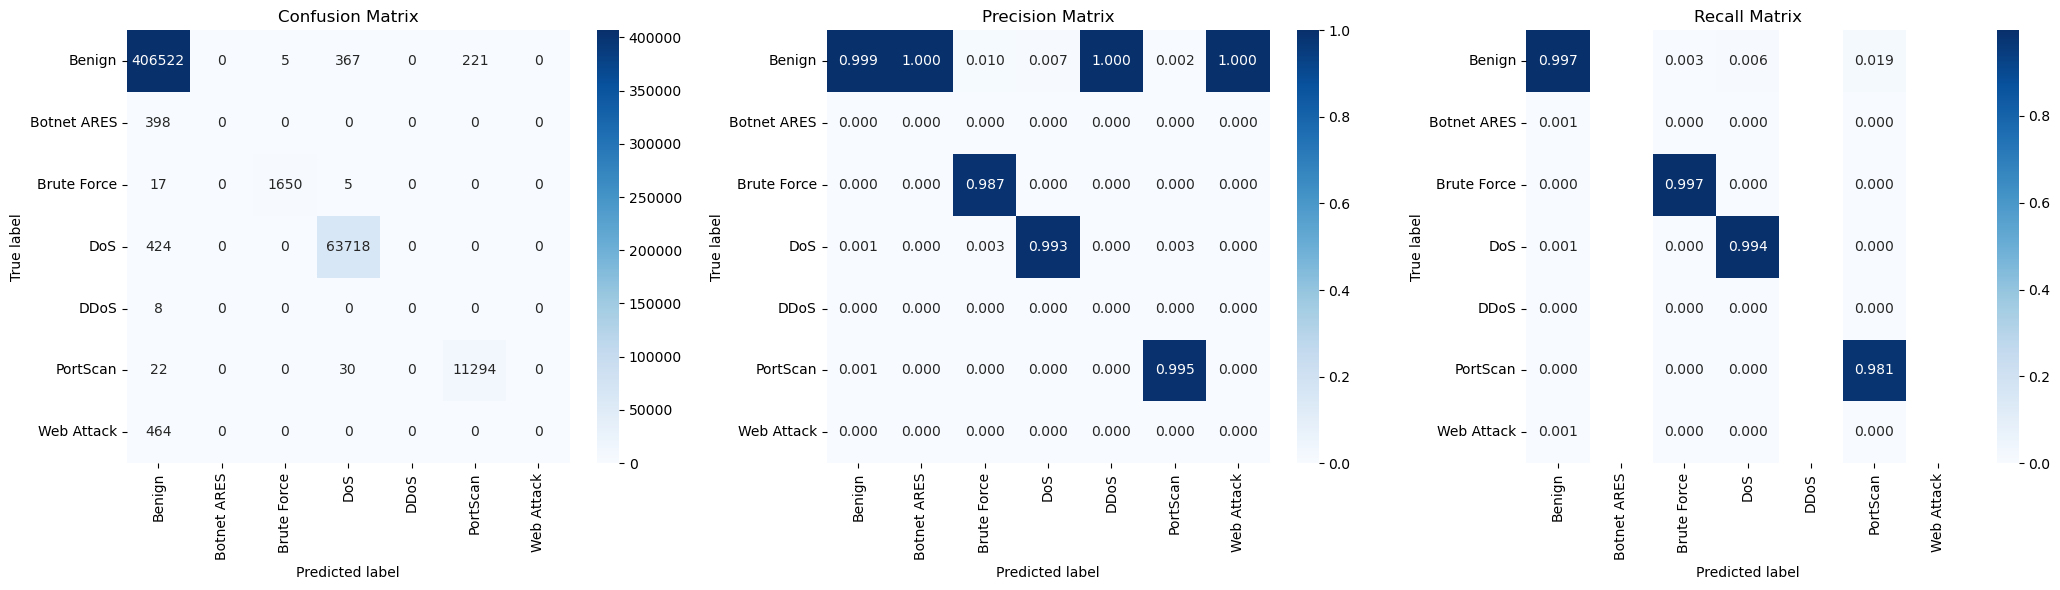

In [17]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_mlp_test_confusion_matrix.pdf")

In [18]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report



/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    407115
 Botnet ARES       0.00      0.00      0.00       398
 Brute Force       1.00      0.99      0.99      1672
         DoS       0.99      0.99      0.99     64142
        DDoS       0.00      0.00      0.00         8
    PortScan       0.98      1.00      0.99     11346
  Web Attack       0.00      0.00      0.00       464

    accuracy                           1.00    485145
   macro avg       0.57      0.57      0.57    485145
weighted avg       0.99      1.00      1.00    485145



/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot ROC curve

In [18]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)

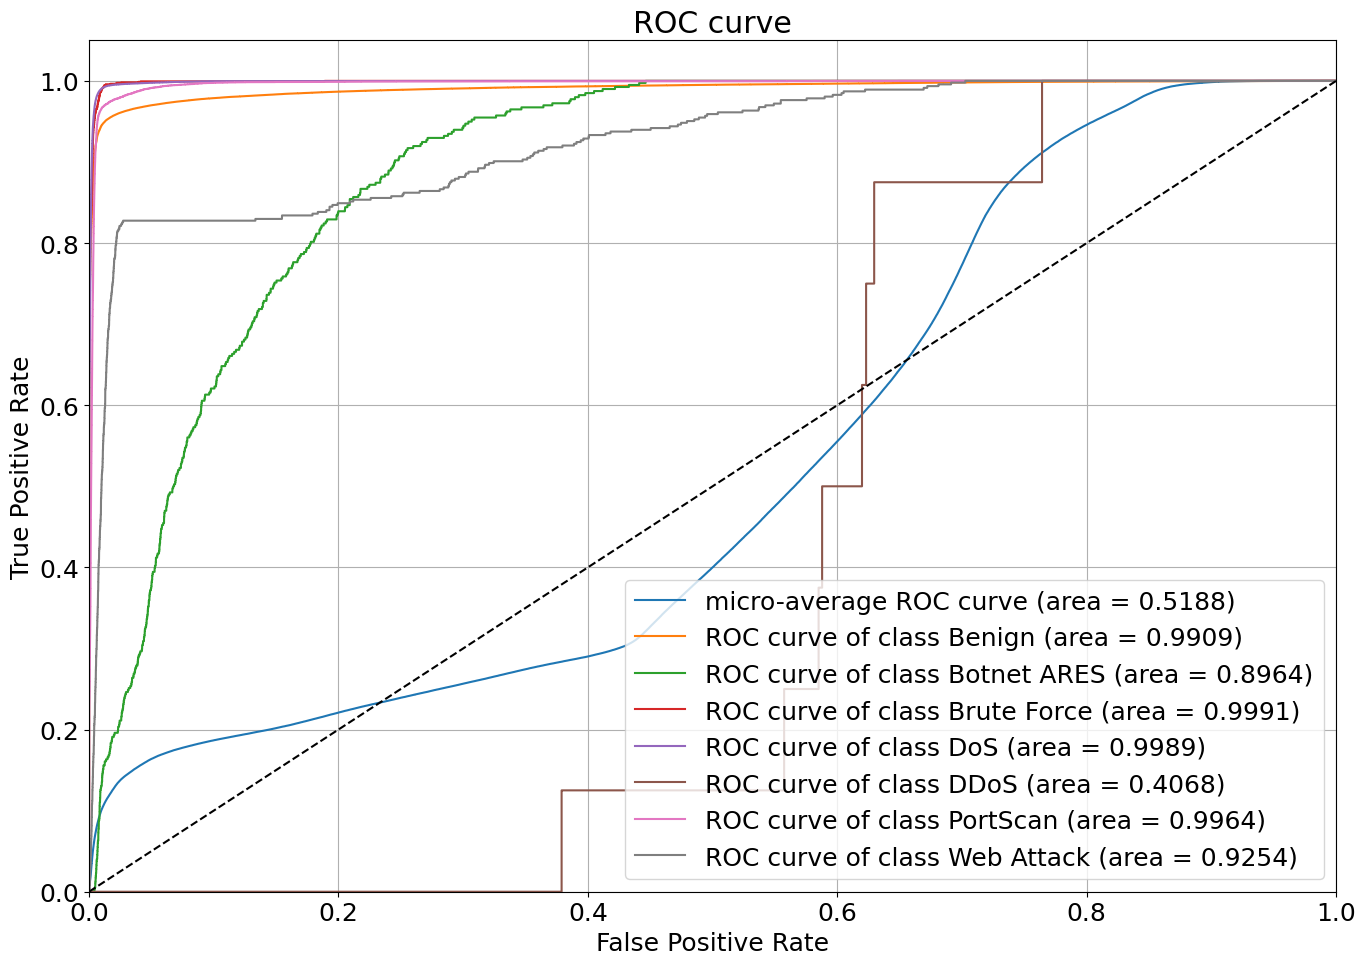

In [24]:
# plt.rcParams['font.size'] = 18  # 设置标签的字体大小
# plt.rcParams['font.family'] = 'Times New Roman'
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS', 'DDoS', 'PortScan', 'Web Attack']
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="imb_mlp_roc_curve2.pdf")

### Plot Precision vs. Recall curve

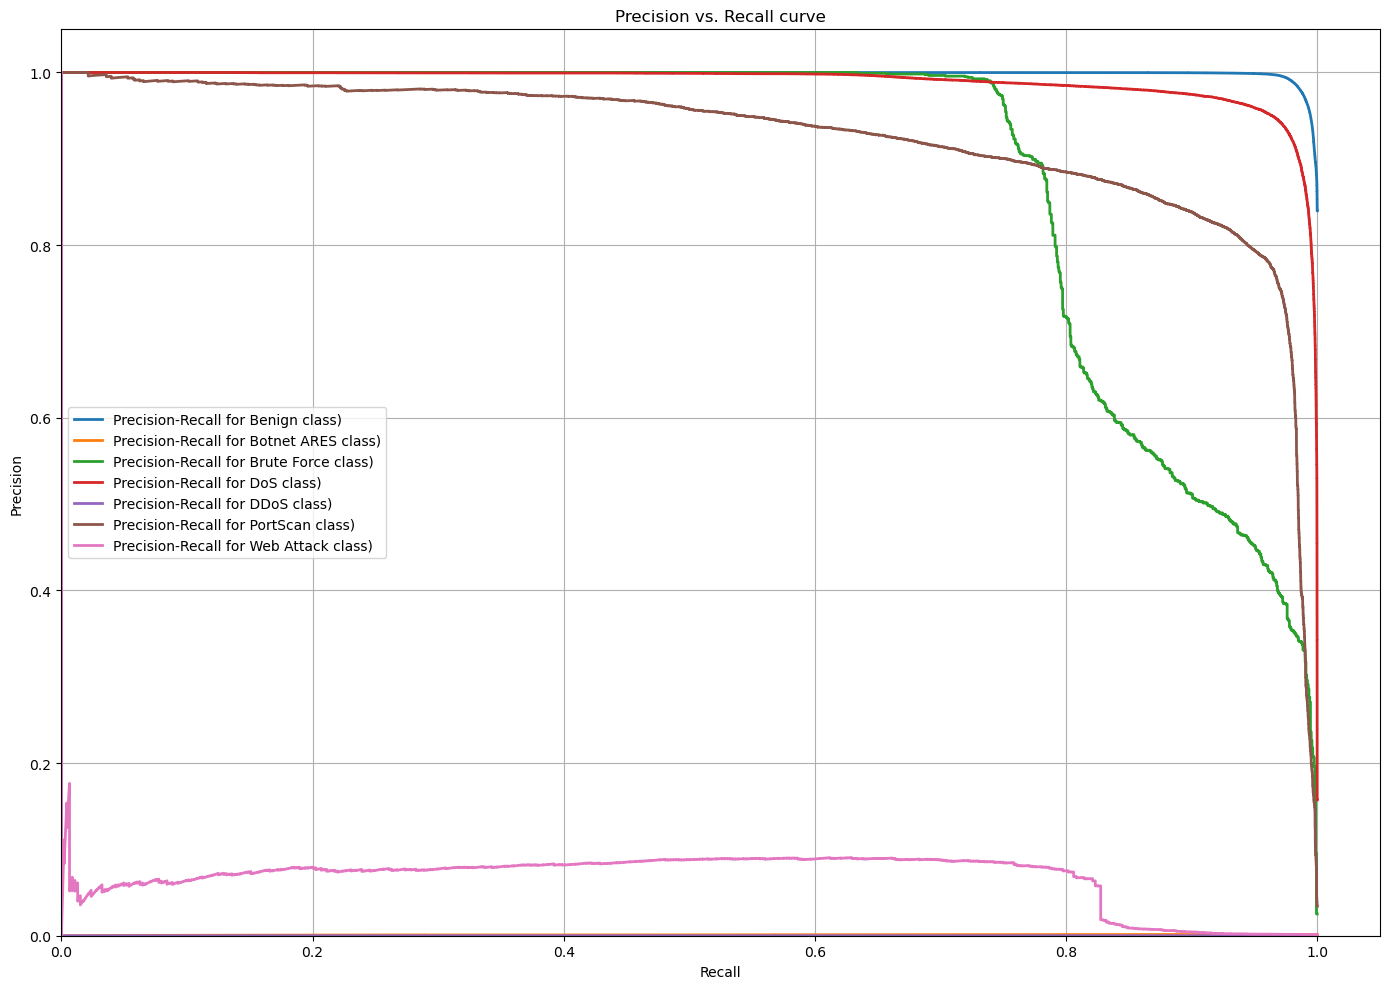

In [21]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="imb_mlp_prec_recall_curve.pdf")

### Save Model

In [ ]:
path = '../../checkpoints/imb_multilayer_perceptron.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            }, path)